# Deep learning examples

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/NN_examples.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebooks contains examples with neural network models.

**Table of Contents**

* [Creating TSDataset](#chapter1)  
* [Architecture](#chapter2)
* [Testing models](#chapter3)
    * [DeepAR](#section_3_1)
    * [TFT](#section_3_2)
    * [Simple Model](#section_3_3)

In [1]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel

import warnings
warnings.filterwarnings("ignore")

## 1. Creating TSDataset <a class="anchor" id="chapter1"></a>

We are going to take transformed [Household Electric Power Consumption] dataset. Let's load and look at it.

In [2]:
original_df = pd.read_csv("data/example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the spacial data structure TSDataset. Let's create it as it was done in "Get started" notebook.

In [3]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


## 2. Architecture <a class="anchor" id="chapter2"></a>

Our library uses [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) to work with time series neural networks. To include it in our current architecture we use `PytorchForecastingTransform` class.

Let's look at it closer.

In [4]:
from etna.transforms import PytorchForecastingTransform

In [5]:
?PytorchForecastingTransform

```python
"""
Init signature:
PytorchForecastingTransform(
    max_encoder_length: int = 30,
    min_encoder_length: int = None,
    min_prediction_idx: int = None,
    min_prediction_length: int = None,
    max_prediction_length: int = 1,
    static_categoricals: List[str] = [],
    static_reals: List[str] = [],
    time_varying_known_categoricals: List[str] = [],
    time_varying_known_reals: List[str] = [],
    time_varying_unknown_categoricals: List[str] = [],
    time_varying_unknown_reals: List[str] = [],
    variable_groups: Dict[str, List[int]] = {},
    constant_fill_strategy: Dict[str, Union[str, float, int, bool]] = {},
    allow_missing_timesteps: bool = True,
    lags: Dict[str, List[int]] = {},
    add_relative_time_idx: bool = True,
    add_target_scales: bool = True,
    add_encoder_length: Union[bool, str] = True,
    target_normalizer: Union[pytorch_forecasting.data.encoders.TorchNormalizer, pytorch_forecasting.data.encoders.NaNLabelEncoder, pytorch_forecasting.data.encoders.EncoderNormalizer, str, List[Union[pytorch_forecasting.data.encoders.TorchNormalizer, pytorch_forecasting.data.encoders.NaNLabelEncoder, pytorch_forecasting.data.encoders.EncoderNormalizer]], Tuple[Union[pytorch_forecasting.data.encoders.TorchNormalizer, pytorch_forecasting.data.encoders.NaNLabelEncoder, pytorch_forecasting.data.encoders.EncoderNormalizer]]] = 'auto',
    categorical_encoders: Dict[str, pytorch_forecasting.data.encoders.NaNLabelEncoder] = None,
    scalers: Dict[str, Union[sklearn.preprocessing._data.StandardScaler, sklearn.preprocessing._data.RobustScaler, pytorch_forecasting.data.encoders.TorchNormalizer, pytorch_forecasting.data.encoders.EncoderNormalizer]] = {},
)
Docstring:      Transform for models from PytorchForecasting library.
Init docstring:
Parameters for TimeSeriesDataSet object.

Reference
---------
https://github.com/jdb78/pytorch-forecasting/blob/v0.8.5/pytorch_forecasting/data/timeseries.py#L117
"""
```

We can see a pretty scary signature, but don't panic, we will look at the most important parameters. 

* `time_varying_known_reals` &mdash; known real values that change across the time (real regressors), now it it necessary to add "time_idx" variable to the list;
* `time_varying_unknown_reals` &mdash; our real value target, set it to `["target"]`;
* `max_prediction_length` &mdash; our horizon for forecasting;
* `max_encoder_length` &mdash; length of past context to use;
* `static_categoricals` &mdash; static categorical values, for example, if we use multiple segments it can be some its characteristics including identifier: "segment";
* `time_varying_known_categoricals` &mdash; known categorical values that change across the time (categorical regressors);
* `target_normalizer` &mdash; class for normalization targets across different segments.

Our library currently supports these models:
* [DeepAR](https://arxiv.org/abs/1704.04110),
* [TFT](https://arxiv.org/abs/1912.09363).

## 3. Testing models <a class="anchor" id="chapter3"></a>

In this section we will test our models on example.

### 3.1 DeepAR <a class="anchor" id="section_3_1"></a>

Before training let's fix seeds for reproducibility.

In [6]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Creating transforms for DeepAR.

In [7]:
from pytorch_forecasting.data import GroupNormalizer

HORIZON = 7

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(in_column="target", lags=[HORIZON+i for i in range(num_lags)], out_column="target_lag")
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

transform_deepar = PytorchForecastingTransform(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"]+lag_columns,
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

Now we are going to start backtest.

In [8]:
from etna.models.nn import DeepARModel


model_deepar = DeepARModel(max_epochs=150, learning_rate=[0.01], gpus=0, batch_size=64)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar,
                           horizon=HORIZON,
                           transforms=[transform_lag, transform_date, transform_deepar])

In [9]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.2min finished


Let's compare results across different segments.

In [10]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,4.367640,4.220231,22.811410,0
0,segment_a,2.709404,2.716348,14.229043,1
0,segment_a,8.239455,7.837179,43.095760,2
2,segment_b,5.530163,5.359430,13.821215,0
2,segment_b,4.451017,4.461790,10.986727,1
2,segment_b,2.343572,2.319901,5.559429,2
3,segment_c,4.632508,4.582476,7.868546,0
3,segment_c,7.238257,6.924132,12.912042,1
3,segment_c,6.714511,6.389917,12.091285,2
1,segment_d,4.964761,4.829586,42.242510,0


To summarize it we will take mean value of SMAPE metric because it is scale tolerant.

In [11]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 4.929


Visualize results.

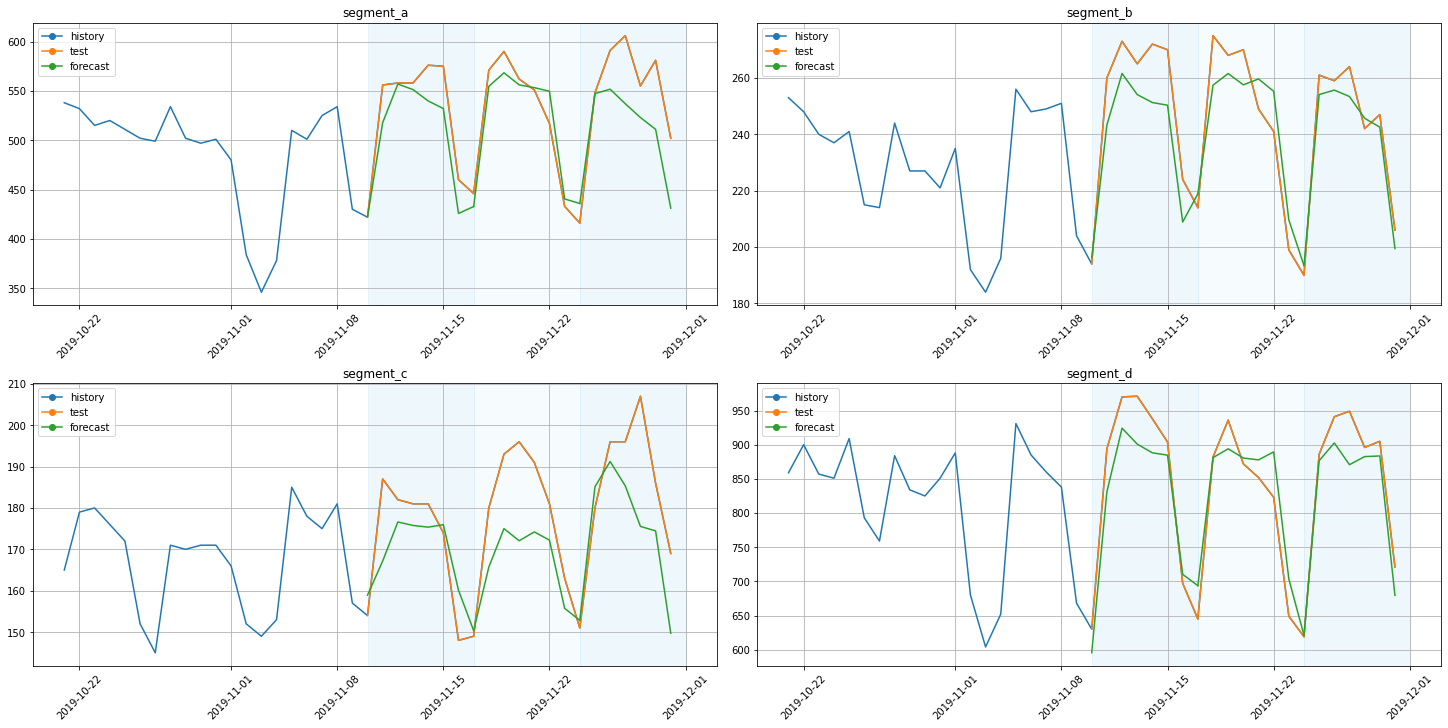

In [12]:
plot_backtest(forecast_deepar, ts, history_len=20)

### 3.2 TFT <a class="anchor" id="section_3_2"></a>

Let's move to the next model.

In [13]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [14]:
transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(in_column="target", lags=[HORIZON+i for i in range(num_lags)], out_column="target_lag")
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

transform_tft = PytorchForecastingTransform(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    static_categoricals=["segment"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

In [15]:
from etna.models.nn import TFTModel

model_tft = TFTModel(max_epochs=200, learning_rate=[0.01], gpus=0, batch_size=64)

pipeline_tft = Pipeline(model=model_tft,
                        horizon=HORIZON,
                        transforms=[transform_lag, transform_date, transform_tft])

In [16]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_contex

Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context

Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.9min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context

Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.4min finished


In [17]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,3.793087,3.677836,19.948386,0
0,segment_a,7.576615,7.539231,39.035937,1
0,segment_a,3.543582,3.517066,18.842791,2
2,segment_b,6.176802,5.891657,15.709222,0
2,segment_b,7.093696,6.966479,16.976512,1
2,segment_b,4.553870,4.696502,11.032102,2
3,segment_c,4.990803,4.917120,8.564157,0
3,segment_c,5.634014,5.446712,10.116394,1
3,segment_c,5.778595,5.596854,10.514284,2
1,segment_d,9.761393,9.563648,82.511100,0


In [18]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 5.547


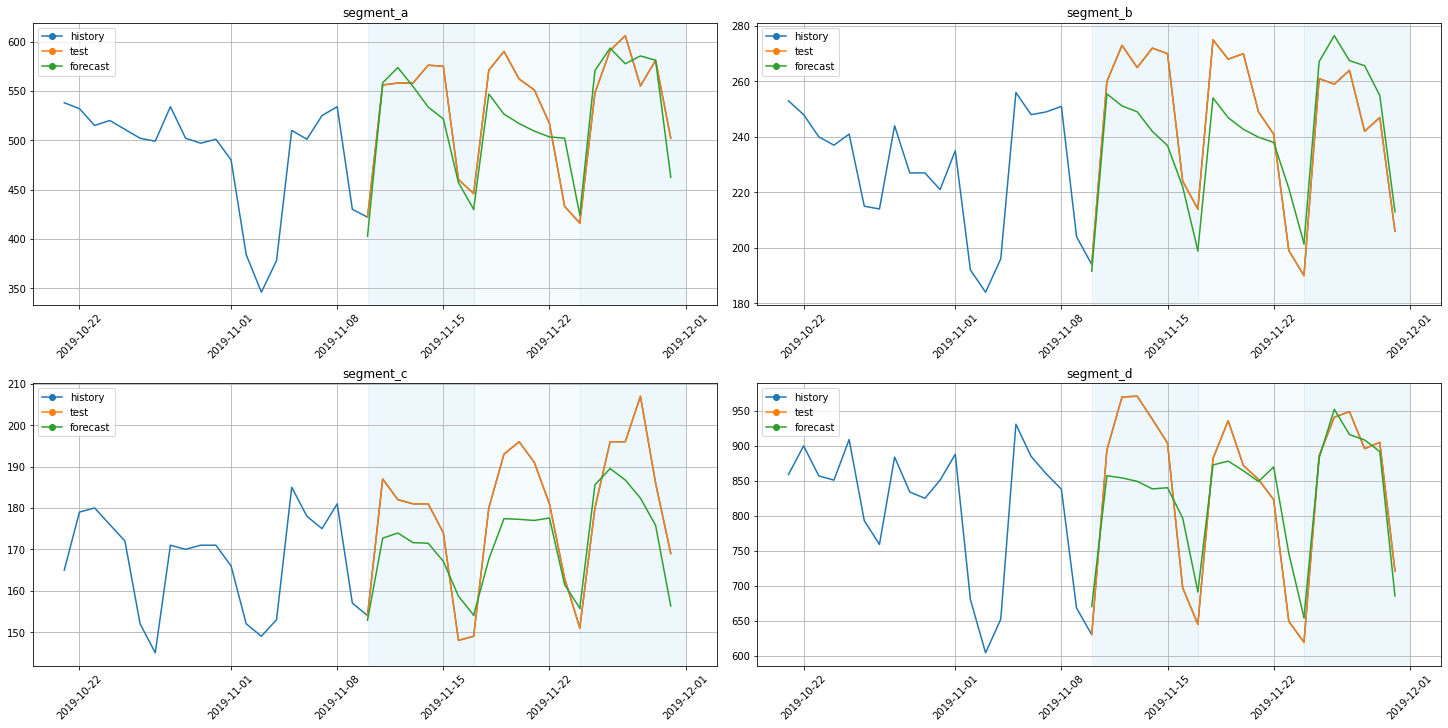

In [19]:
plot_backtest(forecast_tft, ts, history_len=20)

### 3.3 Simple model <a class="anchor" id="section_3_3"></a>

For comparison let's train a much more simpler model.

In [20]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column='target')

pipeline_sma = Pipeline(model=model_sma,
                        horizon=HORIZON,
                        transforms=[linear_trend_transform])

In [21]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished


In [22]:
metrics_sma

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,6.343943,6.124296,33.196532,0
0,segment_a,5.346946,5.192455,27.938101,1
0,segment_a,7.510347,7.189999,40.028565,2
2,segment_b,7.178822,6.920176,17.818102,0
2,segment_b,5.672504,5.554555,13.719200,1
2,segment_b,3.327846,3.359712,7.680919,2
3,segment_c,6.430429,6.200580,10.877718,0
3,segment_c,5.947090,5.727531,10.701336,1
3,segment_c,6.186545,5.943679,11.359563,2
1,segment_d,4.707899,4.644170,39.918646,0


In [23]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 5.547


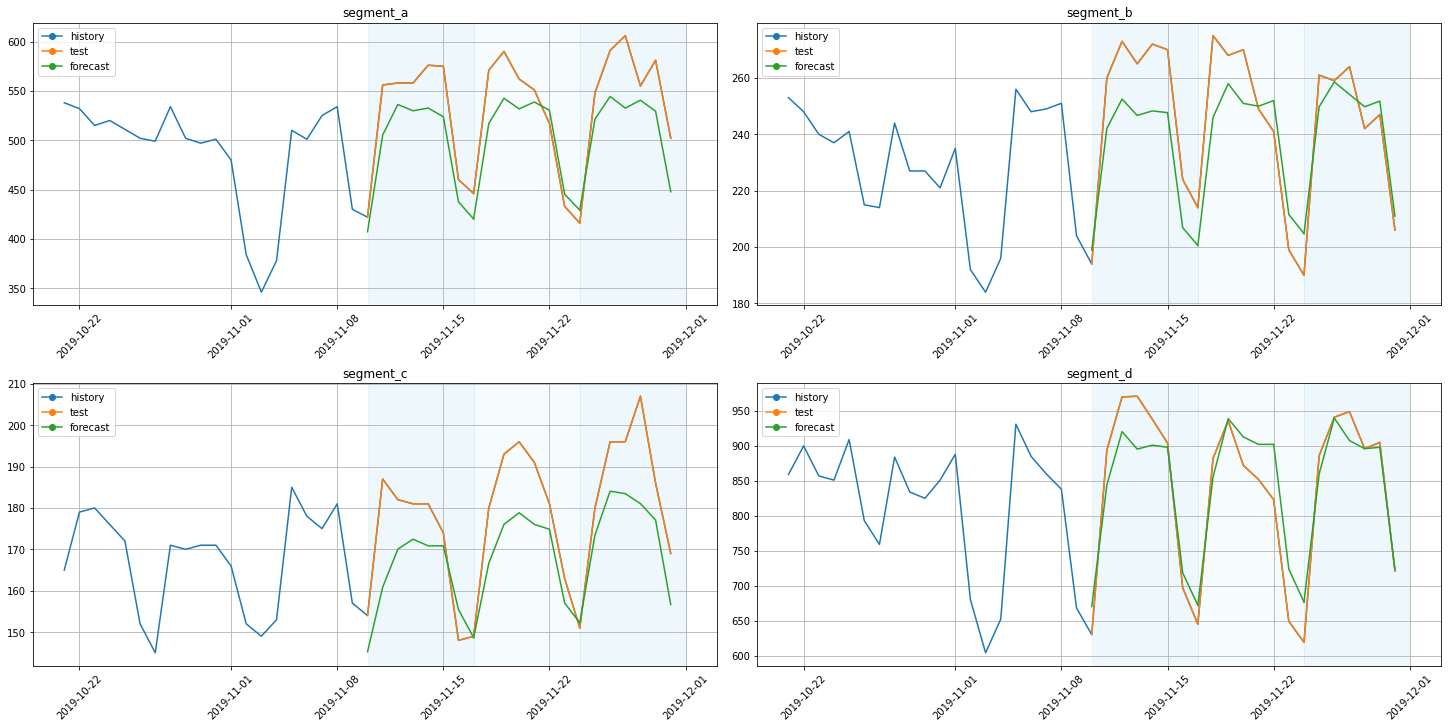

In [24]:
plot_backtest(forecast_sma, ts, history_len=20)

As we can see, neural networks are a bit better in this particular case.